In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis,get_time_plate_info_long_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave,plot_single_plate
import matplotlib.patches as mpatches
import statsmodels.api as sm
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.io as sio
import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns
from scipy.integrate import odeint
import scienceplots
import logging
%store -r path_figure

logging.getLogger().setLevel(logging.WARNING)
%matplotlib widget
plt.style.use('presentation.mplstyle')
# plt.style.use('science')
plates = ['94_20201123']
plate_select = [94]
# plt.rcParams['font.family'] = 'Helvetica'  # Set font family

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
all_analysis_folders = get_analysis_folders()
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]

folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,use_saved=False)
time_plate_info["time_since_begin"] = time_plate_info["time_since_begin"]/pd.Timedelta(hours = 1)
time_plate_info = time_plate_info.sort_values('time_since_begin')
time_plate_info['time_delta'] = -time_plate_info['time_since_begin'].diff(-1)
for index in range(20):
    time_plate_info[f"rhon-{index}"] = time_plate_info[f"ring_active_tips_density_incr-100_index-{index}"]*time_plate_info[f"ring_density_incr-100_index-{index}"]
#     time_plate_info[f"ring_branch_density_incr-100_index-{index}"] = time_plate_info[f"ring_branch_density_incr-100_index-{index}"]/time_plate_info['time_delta'] 
#     time_plate_info[f"ring_anas_density_incr-100_index-{index}"] = time_plate_info[f"ring_anas_density_incr-100_index-{index}"]/time_plate_info['time_delta'] 

folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders)
folders,time_plate_info_long = get_time_plate_info_long_from_analysis(analysis_folders,use_saved=False)
for index in range(20):
    # time_plate_info_long[f"rhon-{index}"] = time_plate_info_long[f"ring_active_tips_density_incr-100_index-{index}"]*time_plate_info[f"ring_density_incr-100_index-{index}"]
    time_plate_info_long[f"rhon-{index}"] = time_plate_info_long[f"ring_active_tips_density_incr-100_index-{index}"]*(time_plate_info[f"ring_density_incr-100_index-{index}"]-time_plate_info_long[f"ring_bas_density_incr-100_index-{index}"])


c:\users\coren\documents\phd\code\amftrack\amftrack\util\sys.py:690: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table["time_since_begin_h"] = (
c:\users\coren\documents\phd\code\amftrack\amftrack\util\sys.py:693: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table["folder"] = line["folder"]
c:\users\coren\documents\phd\code\amftrack\amftrack\util\sys.py:695: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all co

In [3]:
for index in range(20):
    # time_plate_info_long[f"rhon-{index}"] = time_plate_info_long[f"ring_active_tips_density_incr-100_index-{index}"]*time_plate_info[f"ring_density_incr-100_index-{index}"]
    time_plate_info_long[f"rhon2-{index}"] = time_plate_info_long[f"ring_active_tips_density_incr-100_index-{index}"]*(time_plate_info[f"ring_density_incr-100_index-{index}"]-time_plate_info_long[f"ring_bas_density_incr-100_index-{index}"])**2


C:\Users\coren\AppData\Local\Temp\ipykernel_16932\1374940122.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  time_plate_info_long[f"rhon2-{index}"] = time_plate_info_long[f"ring_active_tips_density_incr-100_index-{index}"]*(time_plate_info[f"ring_density_incr-100_index-{index}"]-time_plate_info_long[f"ring_bas_density_incr-100_index-{index}"])**2
C:\Users\coren\AppData\Local\Temp\ipykernel_16932\1374940122.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  time_plate_info_long[f"rhon2-{index}"] = time_plate_info_long[f"ring

In [4]:
width = 1.6
height = 1

In [5]:
def find_t0(index,table):
    column = f"ring_density_incr-100_index-{index}"
    column2 = f"ring_active_tips_density_incr-100_index-{index}"

    start = np.min(
        table.loc[table[column] >= 400]["time_since_begin"]
    )
    table[f"time_since_begin_{index}"] = (
        table["time_since_begin"] - start
    )

    area = np.sqrt(table["area_sep_comp"][0] + 100 * index)
    selection_fit = table
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]

    selection_fit = table

    popt0, pcov = curve_fit(
        S,
        xis,
        yis,
        bounds=([0, 0, -np.inf], 3 * [np.inf]),
        p0=[1, 1, 0],
    )
    lamb, C, t0 = list(popt0)
    return(t0)

In [6]:
def plot_shade(df,xcolumn,ycolumn,color,ax):
    meancurve = df.groupby(xcolumn)[ycolumn].mean()
    stdcurve = df.groupby(xcolumn)[ycolumn].std()
    countcurve = df.groupby(xcolumn)[ycolumn].count()
    err = 2*stdcurve/np.sqrt(countcurve)
    ax.plot(meancurve.index,meancurve,color=color,linewidth = 1)
    ax.fill_between(meancurve.index, meancurve-err, meancurve+err,color=color,alpha = 0.4)
    return(meancurve)

2023-07-20 14:26:38,603-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped
2023-07-20 14:26:39,497-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped
2023-07-20 14:26:40,273-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


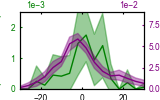

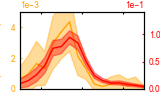

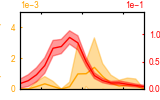

In [7]:
plate = 94

plt.close('all')
table = time_plate_info.loc[time_plate_info["Plate"]==plate].copy()
table_rh = time_plate_info_long.loc[time_plate_info_long["Plate"]==plate].copy()
lim = 100
# table = table.iloc[:lim]
# table_rh = table_rh.iloc[:lim]

ts = []

ys = []
ys2 = []
ys3 = []
ys4 = []
ys5 = []





# ax3.plot(meancurve3.index,meancurve3*meancurve4,linewidth = 5,color='green')


for index in range(15):
    column = f"ring_anas_density_incr-100_index-{index}"
    column2 = f"ring_active_tips_density_incr-100_index-{index}"
    column3 = f"ring_branch_density_incr-100_index-{index}"
    column5 = f"ring_stop_density_incr-100_index-{index}"    
    column4 = f"rhon-{index}"
    
    start1 = np.min(table.loc[table[f"ring_density_incr-100_index-{index}"]>=400]['time_since_begin'])
    start = find_t0(index,table)+start1
    if not np.isnan(start):
        table[f'time_since_begin_{index}']=table['time_since_begin']-start
        # ax.plot(table[f'time_since_begin_{index}'],table[column],alpha=0.2,color='blue')
        # ax2.plot(table[f'time_since_begin_{index}'],table[column2],alpha=0.2,color='red')

        ts +=table[f'time_since_begin_{index}'].to_list()
        ys += table_rh[column].astype(float).to_list()
        ys2+=table_rh[column2].astype(float).to_list()
        ys3+=table_rh[column3].astype(float).to_list()
        ys4+=(table_rh[column4].astype(float)/1000).to_list()
        ys5+=(table_rh[column5].astype(float)).to_list()
        
        
df = pd.DataFrame((np.array((ts,ys,ys2,ys3,ys4,ys5))).transpose(),columns=('ts','ys','ys2','ys3','ys4','ys5'))
factor = 4
df['ts_round'] = (df['ts']/factor).astype(int)*factor+factor/2
xcolumn = 'ts_round'
# meancurve = df.groupby('ts_round')['ys'].mean()
# ax.plot(meancurve.index,meancurve,color="blue",linewidth = 5)



f, ax = plt.subplots(1, 1, sharex=True,figsize=(width,height))

# ax4.set_ylabel(r'branching density ($mm^{-2}.h^{-1}$)')
# plt.tight_layout()

ax3 = ax.twinx()
anas = plot_shade(df,xcolumn,'ys','green',ax)

rhon = plot_shade(df,xcolumn,'ys4','purple',ax3)
ax.set_ylabel('anastomosis rate (a) \n ($mm^{-2}$ $hour^{-1}$)', color='green')

ax.set_xlabel('$t-t_n$ ($h$)')
ax3.set_ylabel(r'$\rho n$ ($mm^{-3}$)', color='purple')
ax.set_ylim((0,0.0025))
ax3.set_ylim((0,0.09))

ax.tick_params(axis='y', colors='green')
ax3.tick_params(axis='y', colors='purple')
ax.set_xlim((-30,30))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.yaxis.offsetText.set_position((0.05, 5))
ax3.yaxis.offsetText.set_position((0.95, 5))

plt.savefig(os.path.join(path_figure,'Figure3D2.pdf'), bbox_inches='tight',transparent=True)

f, ax4 = plt.subplots(1, 1, sharex=True,figsize=(width,height))
ax2 = ax4.twinx()

n = plot_shade(df,xcolumn,'ys2','red',ax2)
branch = plot_shade(df,xcolumn,'ys3','orange',ax4)
ax2.set_ylabel('active tips density (n) \n ($mm^{-2}$)', color='red')
ax4.set_ylabel('branching rate (b)\n ($mm^{-2}$ $h^{-1}$)', color='orange')
ax2.tick_params(axis='y', colors='red')
ax4.tick_params(axis='y', colors='orange')
ax4.set_ylim((0,0.0050))

ax2.set_xlim((-30,30))
ax2.set_ylim((0,0.140))
ax2.set_xticklabels([])
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# plt.savefig(os.path.join(path_figure,'Figure3D.png'))
# plt.savefig(os.path.join(path_figure,'Figure3D.EPS'))
plt.savefig(os.path.join(path_figure,'Figure3D1.pdf'), bbox_inches='tight',transparent=True)
f, ax4 = plt.subplots(1, 1, sharex=True,figsize=(width,height))
ax2 = ax4.twinx()

n = plot_shade(df,xcolumn,'ys2','red',ax2)
branch = plot_shade(df,xcolumn,'ys5','orange',ax4)
ax2.set_ylabel('active tips density (n) \n ($mm^{-2}$)', color='red')
ax4.set_ylabel('stop rate (b)\n ($mm^{-2}$ $h^{-1}$)', color='orange')
ax2.tick_params(axis='y', colors='red')
ax4.tick_params(axis='y', colors='orange')
ax4.set_ylim((0,0.0025))
ax4.set_ylim((0,0.005))

ax2.set_xlim((-30,30))
ax2.set_ylim((0,0.140))
ax2.set_xticklabels([])
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# plt.savefig(os.path.join(path_figure,'Figure3D.png'))
# plt.savefig(os.path.join(path_figure,'Figure3D.EPS'))
plt.savefig(os.path.join(path_figure,'Figure3B0_rh.pdf'), bbox_inches='tight',transparent=True)



In [8]:
def find_alpha(A, B):
    if len(A) != len(B):
        raise ValueError("Input arrays must have the same length")

    covariance = np.cov(A, B)[0, 1]
    variance = np.var(B, ddof=1)

    alpha = covariance / variance

    return alpha

In [9]:
select = df.loc[df['ts_round'].between(-30,10)]

alpha = find_alpha(select.groupby(xcolumn)['ys3'].mean(), select.groupby(xcolumn)['ys2'].mean())

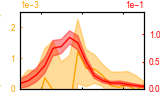

In [10]:
f, ax4 = plt.subplots(1, 1, sharex=True,figsize=(width,height))
df['residuals']=alpha*df['ys2']-df['ys3']
ax2 = ax4.twinx()

n = plot_shade(df,xcolumn,'ys2','red',ax2)
branch = plot_shade(df,xcolumn,'residuals','orange',ax4)
ax2.set_ylabel('active tips density (n) \n ($mm^{-2}$)', color='red')
ax4.set_ylabel('residuals (b)\n ($mm^{-2}.hour^{-1}$)', color='orange')
ax2.tick_params(axis='y', colors='red')
ax4.tick_params(axis='y', colors='orange')
ax4.set_ylim((0,0.0025))

ax2.set_xlim((-30,30))
ax2.set_ylim((0,0.140))
ax2.set_xticklabels([])
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

In [11]:
select = df.loc[df['ts_round'].between(-20,20)]


beta = find_alpha(select.groupby(xcolumn)['ys'].mean(), select.groupby(xcolumn)['ys4'].mean())

In [12]:
beta

0.022696392049046145

In [57]:
select1 = df.loc[df['ts_round'].between(-5,15)]
select2 = df.loc[df['ts_round'].between(-15,5)]
beta = find_alpha(select1.groupby(xcolumn)['ys'].mean().values, select2.groupby(xcolumn)['ys4'].mean().values)

In [55]:
beta

-0.018140248146257646

In [58]:
select1.groupby(xcolumn)['ys'].mean().values/select2.groupby(xcolumn)['ys4'].mean().values

array([0.0588748 , 0.05467212, 0.01791064, 0.02410855, 0.00700982])

In [48]:
len(select1.groupby(xcolumn)['ys'].mean())

5

In [49]:
len(select2.groupby(xcolumn)['ys4'].mean())

5

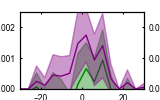

In [91]:
f, ax = plt.subplots(1, 1, sharex=True,figsize=(width,height))
df['residuals2']=df['ys']-beta*df['ys4']
ax3 = ax.twinx()

anas = plot_shade(df,xcolumn,'residuals2','green',ax)

rhon = plot_shade(df,xcolumn,'ys','purple',ax3)
ax.set_ylabel('anastomosis rate (a) \n ($mm^{-2}.hour^{-1}$)', color='green')

ax.set_xlabel('shifted time, $t-t_n$ ($hour$)')
ax3.set_ylabel(r'$\rho n$ ($mm^{-3}$)', color='purple')
ax.set_ylim((0,0.0025))
ax3.set_ylim((0,0.0025))
ax.set_xlim((-30,30))

ax2.set_xticklabels([])
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

In [51]:
select = df.loc[df['ts_round'].between(-20,20)]

betap = find_alpha(select.groupby(xcolumn)['ys5'].mean(), select.groupby(xcolumn)['ys4'].mean())

In [52]:
select = df.loc[df['ts_round'].between(-20,20)]

betapp = find_alpha(select.groupby(xcolumn)['residuals'].mean(), select.groupby(xcolumn)['ys4'].mean())

In [97]:
select = df.loc[df['ts_round'].between(-20,20)]

betappp = find_alpha(select.groupby(xcolumn)['residuals2'].mean(), select.groupby(xcolumn)['ys6'].mean())

KeyError: 'Column not found: residuals2'

In [93]:
betappp

2.1237070017676287e-18

In [53]:
beta+betap+betapp

0.038559514516427806

In [100]:
beta,alpha,betap,betapp

(0.022696392049046145,
 0.039708028873099994,
 0.008900460122446836,
 0.006962662344934827)

In [39]:
beta

0.022696392049046145

In [17]:
24*alpha

0.9529926929543999

In [20]:
2*280/alpha

14102.94129153737

In [101]:
2*alpha/(beta+betap+betapp)*1

2.059570996734561

In [99]:
2*alpha/beta

3.499060889263128

In [37]:
def find_alpha(A, B):
    if len(A) != len(B):
        raise ValueError("Input arrays must have the same length")
    alpha = np.dot(B, A) / np.dot(B, B)
    return alpha

In [44]:
A = np.array([1, 2, 3, 4, 5])
B = np.array([2, 5, 7, 8, 10])

alpha = find_alpha(B, A)

print("Alpha:", alpha)

Alpha: 2.090909090909091


In [159]:
select = df.loc[df['ts_round'].between(0,5)]
beta = np.mean(select.groupby(xcolumn)['ys'].mean()/select.groupby(xcolumn)['ys4'].mean())

In [70]:
select = df.loc[df['ts_round'].between(-20,0)]
alpha = np.mean(select.groupby(xcolumn)['ys3'].mean()/select.groupby(xcolumn)['ys2'].mean())
alpha

0.03829408558127802

In [80]:
select = df.loc[df['ts_round'].between(-10,10)]
alphap = np.mean(select.groupby(xcolumn)['ys5'].mean()/select.groupby(xcolumn)['ys2'].mean())

In [142]:
select = df.loc[df['ts_round'].between(-10,15)]
betap = np.mean(select.groupby(xcolumn)['ys5'].mean()/select.groupby(xcolumn)['ys4'].mean())

In [160]:
beta,betap,betap+beta

(0.029845339143744383, 0.017323647043303796, 0.04716898618704818)

In [161]:
2*alpha / (beta+betap)

1.6236976317202654

In [162]:
2*alpha / beta

2.566168566344102

In [115]:
alpha,alphap

(0.03906992022370305, 0.1243100259933062)

In [103]:
1/alpha

25.01364534939627

2023-07-18 22:33:34,524-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped
2023-07-18 22:33:35,471-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


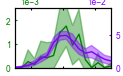

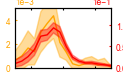

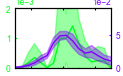

In [21]:
reduce = 1.3
width = 1.6/reduce
height = 1/reduce
purple = (0.5, 0.0, 1.0) 
green = (0,1,0.1)
plate = 94
plt.close('all')
table = time_plate_info.loc[time_plate_info["Plate"]==plate].copy()
table_rh = time_plate_info_long.loc[time_plate_info_long["Plate"]==plate].copy()
lim = 100
# table = table.iloc[:lim]
# table_rh = table_rh.iloc[:lim]

ts = []

ys = []
ys2 = []
ys3 = []
ys4 = []
ys5 = []





# ax3.plot(meancurve3.index,meancurve3*meancurve4,linewidth = 5,color='green')


for index in range(15):
    column = f"ring_anas_density_incr-100_index-{index}"
    column2 = f"ring_active_tips_density_incr-100_index-{index}"
    column3 = f"ring_branch_density_incr-100_index-{index}"
    column5 = f"ring_stop_density_incr-100_index-{index}"    
    column4 = f"rhon2-{index}"
    
    start1 = np.min(table.loc[table[f"ring_density_incr-100_index-{index}"]>=400]['time_since_begin'])
    start = find_t0(index,table)+start1
    if not np.isnan(start):
        table[f'time_since_begin_{index}']=table['time_since_begin']-start
        # ax.plot(table[f'time_since_begin_{index}'],table[column],alpha=0.2,color='blue')
        # ax2.plot(table[f'time_since_begin_{index}'],table[column2],alpha=0.2,color='red')

        ts +=table[f'time_since_begin_{index}'].to_list()
        ys += table_rh[column].astype(float).to_list()
        ys2+=table_rh[column2].astype(float).to_list()
        ys3+=table_rh[column3].astype(float).to_list()
        ys4+=(table_rh[column4].astype(float)/1e6).to_list()
        ys5+=(table_rh[column5].astype(float)).to_list()
        
        
df = pd.DataFrame((np.array((ts,ys,ys2,ys3,ys4,ys5))).transpose(),columns=('ts','ys','ys2','ys3','ys6','ys5'))
factor = 4
df['ts_round'] = (df['ts']/factor).astype(int)*factor+factor/2
xcolumn = 'ts_round'
# meancurve = df.groupby('ts_round')['ys'].mean()
# ax.plot(meancurve.index,meancurve,color="blue",linewidth = 5)



f, ax = plt.subplots(1, 1, sharex=True,figsize=(width,height))

# ax4.set_ylabel(r'branching density ($mm^{-2}.h^{-1}$)')
# plt.tight_layout()

ax3 = ax.twinx()
anas = plot_shade(df,xcolumn,'ys','green',ax)

rhon = plot_shade(df,xcolumn,'ys6',purple,ax3)
ax.set_ylabel('anastomosis rate (a) \n ($mm^{-2}$ $h^{-1}$)', color='green')

# ax.set_xlabel('shifted time, $t-t_n$ ($hour$)')
ax3.set_ylabel(r'$\rho^2 n$ ($mm^{-3}$)', color=purple)
ax.set_ylim((0,0.0025))
ax3.set_ylim((0,0.090))
ax.set_xticklabels([])

ax.tick_params(axis='y', colors='green')
ax3.tick_params(axis='y', colors=purple)
ax.set_xlim((-30,30))
ax.set_xticklabels([])

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.yaxis.offsetText.set_position((0.05, 5))
ax3.yaxis.offsetText.set_position((0.95, 5))
plt.savefig(os.path.join(path_figure,'nrho2.pdf'), bbox_inches='tight',transparent=True)


f, ax4 = plt.subplots(1, 1, sharex=True,figsize=(width,height))
ax2 = ax4.twinx()

n = plot_shade(df,xcolumn,'ys2','red',ax2)
branch = plot_shade(df,xcolumn,'ys3','orange',ax4)
ax2.set_ylabel(r'$\rho^2 n$ ($mm^{-3}$)', color='red')
ax4.set_ylabel('branching rate (b)\n ($mm^{-2}$ $h^{-1}$)', color='orange')
# ax2.set_xlabel('shifted time, $t-t_n$ ($hour$)')

ax2.tick_params(axis='y', colors='red')
ax4.tick_params(axis='y', colors='orange')
ax4.set_ylim((0,0.0050))

ax2.set_xlim((-30,30))
ax2.set_ylim((0,0.140))
ax2.set_xticklabels([])
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# plt.savefig(os.path.join(path_figure,'Figure3D.png'))
# plt.savefig(os.path.join(path_figure,'Figure3D.EPS'))
f, ax4 = plt.subplots(1, 1, sharex=True,figsize=(width,height))
ax2 = ax4.twinx()

rhon = plot_shade(df,xcolumn,'ys6',purple,ax2)

branch = plot_shade(df,xcolumn,'ys5',green,ax4)
ax2.set_ylabel(r'$\rho^2 n$ ($mm^{-3}$)', color=purple)
ax4.set_ylabel('stop rate (b)\n ($mm^{-2}$ $h^{-1}$)', color=green)
ax2.set_xlabel('shifted time, $t-t_n$ ($h$)')

ax2.tick_params(axis='y', colors=purple)
ax4.tick_params(axis='y', colors=green)
ax4.set_ylim((0,0.002))

ax2.set_xlim((-30,30))
ax2.set_ylim((0,0.090))
ax2.set_xticklabels([])
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig(os.path.join(path_figure,'stopnrho2.pdf'), bbox_inches='tight',transparent=True)

# plt.savefig(os.path.join(path_figure,'Figure3D.png'))
# plt.savefig(os.path.join(path_figure,'Figure3D.EPS'))



In [67]:
select = df.loc[df['ts_round'].between(-20,20)]
betappp = find_alpha(select.groupby(xcolumn)['ys'].mean(), select.groupby(xcolumn)['ys6'].mean())

In [68]:
betappp

0.03278739166265

In [107]:
np.sqrt(3*alpha / beta)

2.290980430709676

2023-07-18 22:33:37,019-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


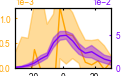

In [22]:

f, ax4 = plt.subplots(1, 1, sharex=True,figsize=(width,height))
df['residuals']=alpha*df['ys2']-df['ys3']
ax2 = ax4.twinx()

rhon = plot_shade(df,xcolumn,'ys6',purple,ax2)
branch = plot_shade(df,xcolumn,'residuals','orange',ax4)
ax2.set_ylabel(r'$\rho^2 n$ ($mm^{-3}$)', color=purple)
ax4.set_ylabel(r'$\alpha n -b(n)$'+ '\n' +'($mm^{-2}$ $h^{-1}$)', color='orange')

ax2.tick_params(axis='y', colors=purple)
ax4.tick_params(axis='y', colors='orange')
ax4.set_ylim((0,0.0012))

ax2.set_xlim((-30,30))
ax2.set_ylim((0,0.090))
# ax2.set_xticklabels([])
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax4.set_xlabel('shifted time, $t-t_n$ ($h$)')

plt.savefig(os.path.join(path_figure,'resiualsnrho2.pdf'), bbox_inches='tight',transparent=True)


In [72]:
select = df.loc[df['ts_round'].between(-20,20)]

betap = find_alpha(select.groupby(xcolumn)['ys5'].mean(), select.groupby(xcolumn)['ys6'].mean())
select = df.loc[df['ts_round'].between(-20,20)]

betapp = find_alpha(select.groupby(xcolumn)['residuals'].mean(), select.groupby(xcolumn)['ys6'].mean())

In [73]:
betappp,betapp,betap

(0.03278739166265, 0.01918689132264254, 0.022594506339994457)

In [112]:
np.sqrt(3*alpha / (betappp+betapp+betap))

1.2595456776085592

In [86]:
(betappp+betapp+betap)

0.07456878932528699